In [68]:
from datetime import date, timedelta, timezone
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
import util
import os

download the model, then download the next 7 days weather forecast -make prediction, and dashboard

In [69]:
today = datetime.now() - timedelta(0)
tomorrow = today + timedelta(days = 1)
today

datetime.datetime(2024, 11, 15, 15, 30, 53, 248639)

In [70]:
project = hopsworks.login(project="dbillLab1")
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169559
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [71]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

Model registry

In [72]:
mr= project.get_model_registry()

retrieved_model=mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

saved_model_dir=retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [73]:
retrieved_xgboost_model=XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir+"/model.json")

retrieved_xgboost_model

XGBRegressor(base_score='2.4923306E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [94]:
weather_fg= fs.get_feature_group(
    name='weather',
    version=1,
)

batch_data= weather_fg.filter(weather_fg.date >= today).read()
batch_data = batch_data.sort_values(by=['date']).reset_index(drop=True)

batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-16 00:00:00+00:00,9.95,0.0,21.413191,253.392929,stockholm
1,2024-11-17 00:00:00+00:00,6.05,0.0,16.071491,254.407120,stockholm
2,2024-11-18 00:00:00+00:00,3.30,0.0,8.557102,292.249084,stockholm
3,2024-11-19 00:00:00+00:00,2.45,0.0,1.800000,143.130020,stockholm
4,2024-11-20 00:00:00+00:00,5.70,2.5,13.044722,140.599365,stockholm
5,2024-11-21 00:00:00+00:00,3.30,0.2,14.145756,165.256393,stockholm
6,2024-11-22 00:00:00+00:00,2.35,0.1,13.044724,242.020615,stockholm
7,2024-11-23 00:00:00+00:00,-0.35,0.0,9.504273,245.376450,stockholm
8,2024-11-24 00:00:00+00:00,-1.60,0.0,10.853866,275.710510,stockholm


In [114]:
def get_pm25_value(data_frame,date):
    print(date)
    #print(data_frame.loc[data_frame["date"] == date, "pm25"].values)
    print("eller", type(data_frame["date"][0]))
    result = data_frame.loc[data_frame["date"] == date, "pm25"].values
    return
    if len(result) > 0:
        result=data_frame.loc[data_frame["date"] == date, "pm25"].values
    else:
        result=data_frame.loc[data_frame["date"] == date, "predicted_pm25"].values
    return result

air_quality_fg= fs.get_feature_group(
    name='air_quality',
    version=1,
)
#air_quality_df=air_quality_fg.read()        #makes it a dataframe
aq_batch_data= air_quality_fg.read()
aq_batch_data = aq_batch_data.sort_values(by=['date']).reset_index(drop=True)

for row in range(len(batch_data)):          #Iterative prediction for the forecasted days
    batch1=batch_data.loc[row,['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]

    current_day=batch_data.loc[row,['date']]
    previous_days=[]
    for go_back in range(1,4):
        day=current_day-timedelta(days = go_back)
        pm25_value=get_pm25_value(aq_batch_data, day)
        previous_days.append(pm25_value)
    #retrieved_xgboost_model.predict(batch_data1)
    #air_quality_fg.insert(aq_today_df)  #insert air quality to feature store
    
#batch_data_sorted.iterrows()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.26s) 
date    2024-11-15 00:00:00+00:00
Name: 0, dtype: object
eller <class 'pandas._libs.tslibs.timestamps.Timestamp'>


ValueError: Can only compare identically-labeled Series objects

In [76]:
# Iterative prediction:
# Sort the batch data
batch_data = batch_data.sort_values(by=['date'])

# Taking the last data with pm_25, 3 days ago value
true_values= batch_data[['pm25_1_day_before', 'pm25_2_days_before', 'pm25_3_days_before']].iloc[-1].tolist()
predictions=[]

for i in range(future_days):
    # Create a DataFrame with the current values
    current_df = pd.DataFrame([true_values], columns=['pm25_1_day_before', 'pm25_2_days_before', 'pm25_3_days_before'])
    
    # Predict the next day's temperature
    predicted_temp = retrieved_xgboost_model.predict(current_df)[0]
    predictions.append(predicted_temp)
    
    # Update last_values to shift the lagged data and include the new prediction
    last_values = [predicted_temp] + true_values[:-1]

print(predictions)

batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

KeyError: "None of [Index(['pm25_1_day_before', 'pm25_2_days_before', 'pm25_3_days_before'], dtype='object')] are in the [columns]"

In [ ]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 456.0+ bytes


In [ ]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
7,2024-11-14 00:00:00+00:00,5.80,0.0,15.021105,315.970917,stockholm,21.345659,stockholm-st-eriksgatan-83,sweden,8
6,2024-11-15 00:00:00+00:00,6.80,0.0,9.064569,276.842682,stockholm,47.433525,stockholm-st-eriksgatan-83,sweden,7
0,2024-11-16 00:00:00+00:00,10.80,0.0,26.260265,241.326950,stockholm,23.896992,stockholm-st-eriksgatan-83,sweden,1
2,2024-11-17 00:00:00+00:00,5.00,0.6,20.371038,223.567963,stockholm,17.914429,stockholm-st-eriksgatan-83,sweden,3
4,2024-11-18 00:00:00+00:00,4.60,0.0,14.044615,268.531219,stockholm,46.973515,stockholm-st-eriksgatan-83,sweden,5
5,2024-11-19 00:00:00+00:00,1.45,0.0,4.334974,311.633453,stockholm,35.223186,stockholm-st-eriksgatan-83,sweden,6
8,2024-11-20 00:00:00+00:00,3.30,1.4,23.402769,89.118622,stockholm,21.155310,stockholm-st-eriksgatan-83,sweden,9
1,2024-11-21 00:00:00+00:00,6.90,1.1,11.367109,259.045990,stockholm,19.206646,stockholm-st-eriksgatan-83,sweden,2
3,2024-11-22 00:00:00+00:00,1.50,1.8,30.302078,256.954346,stockholm,7.431922,stockholm-st-eriksgatan-83,sweden,4


In [ ]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 7 to 3
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   street                       9 non-null      object             
 8   country                      9 non-null      object             
 9   days_before_forecast_day     9 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), object(3)


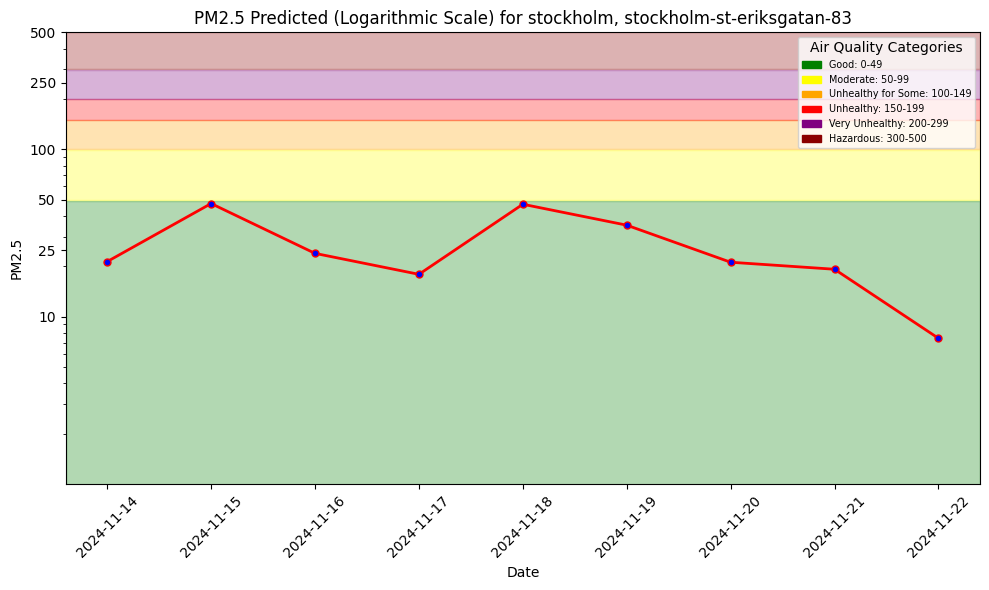

In [ ]:
file_path = "docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [ ]:
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1157270/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x3124d09e0>, None)

In [ ]:
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.72s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-16 00:00:00+00:00,10.80,0.0,26.260265,241.326950,stockholm,23.896992,stockholm-st-eriksgatan-83,sweden,1
1,2024-11-13 00:00:00+00:00,4.75,0.0,14.799459,228.945282,stockholm,48.688534,stockholm-st-eriksgatan-83,sweden,1


In [ ]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.32s) 


,date,pm25,country,city,street,url
0,2021-06-27 00:00:00+00:00,24.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
1,2023-12-15 00:00:00+00:00,24.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
2,2024-09-22 00:00:00+00:00,10.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
3,2021-11-09 00:00:00+00:00,20.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
4,2021-04-24 00:00:00+00:00,9.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
...,...,...,...,...,...,...
2179,2021-12-16 00:00:00+00:00,12.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
2180,2019-03-24 00:00:00+00:00,25.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
2181,2020-03-13 00:00:00+00:00,17.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
2182,2021-01-18 00:00:00+00:00,26.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523


In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-13 00:00:00+00:00,48.688534,17.0


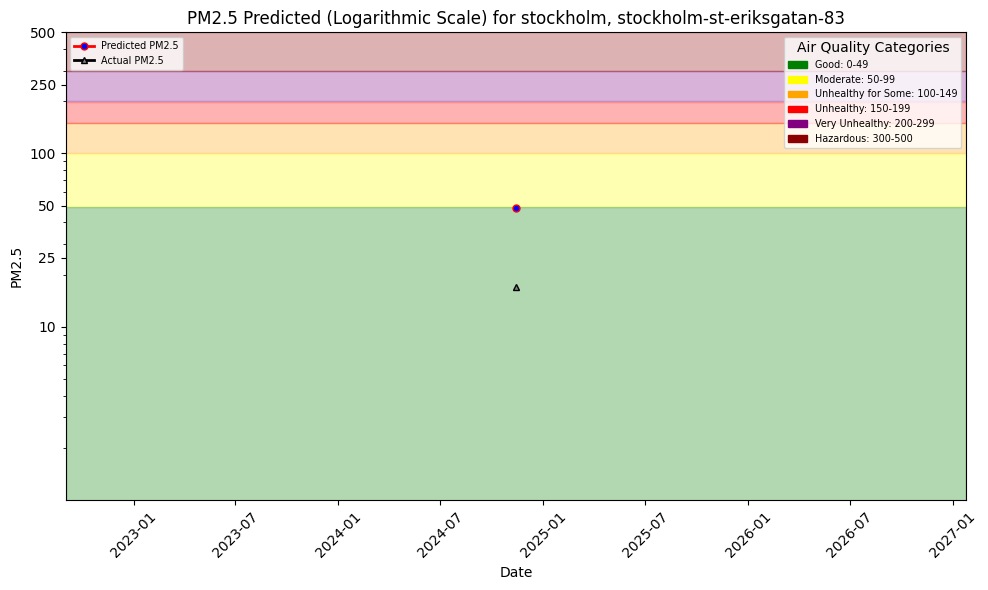

In [ ]:
file_path = "docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()